# Exp9: Use classifiers to assess grammar complexity

In [1]:
import pandas as pd
import spacy

import numpy as np
import matplotlib.pyplot as plt

import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))
import config
sys.path.append('../src')
import models

nlp = spacy.load("en_core_web_sm")

/scratch_local/mpb672-5192431/tmp/ipykernel_287868/3628496897.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/mnt/qb/work/meurers/mpb672/conda_envs/llm2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
import importlib
importlib.reload(models)

<module 'models' from '/mnt/qb/work/meurers/mpb672/LLM-grammar/exp/../src/models.py'>

In [8]:
df = pd.read_json('../dat/egp_merged.json')
level_models = {level: models.load_model(level, df) for level in ["A1", "A2", "B1", "B2", "C1", "C2"]}

In [4]:
def get_sentences(text):
    doc = nlp(text)
    sentences = [token.text.strip() for token in doc.sents]
    return list(sentences)

In [29]:
texts

,text,label,sentences,scores,score
654,﻿Our new international survey across 33 countr...,C1,﻿Our new international survey across 33 countr...,0.0,NaN
654,﻿Our new international survey across 33 countr...,C1,British people think the top 1% wealthiest hou...,0.0,NaN
654,﻿Our new international survey across 33 countr...,C1,Americans think that 33% of their population a...,0.0,NaN
654,﻿Our new international survey across 33 countr...,C1,Brazilians think the average age in their coun...,0.0,NaN
654,﻿Our new international survey across 33 countr...,C1,Russians think that 31% of their politicians a...,0.0,NaN
...,...,...,...,...,...
31,Bob knew that the house he just purchased was ...,B2,This not only lowered his monthly electric bil...,0.0,NaN
31,Bob knew that the house he just purchased was ...,B2,"Within two years, all the changes Bob made to ...",0.0,NaN
31,Bob knew that the house he just purchased was ...,B2,In that time the value of his home rose almost...,0.0,NaN
31,Bob knew that the house he just purchased was ...,B2,Bob felt he made a good investment.,0.0,NaN


In [60]:
def get_corresponding_scores(file="../dat/cefr_leveled_texts.csv", sample_frac=1, all_levels=True):
    texts = pd.read_csv(file)
    texts = texts.sample(frac=sample_frac)
    texts["sentences"] = texts.text.apply(get_sentences)
    texts = texts.dropna().explode("sentences")
    for level in texts.label.unique():
        filter = texts['label'].notnan() if all_levels else texts['label']==level
        sentences_level = texts.loc[filter, 'sentences']
        print(f'{len(sentences_level)} sentences on level {level}')
        scores = models.get_scores(level_models[level], sentences_level, use_tqdm=True)
        texts.loc[filter, f'{level}_score' if all_levels else 'score'] = scores.float().mean(dim=1).cpu().numpy()
    return texts

In [61]:
texts = get_corresponding_scores(sample_frac=1, all_levels=False)

5997 sentences on level A2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:14<00:00, 12.71it/s]


5547 sentences on level C2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 174/174 [00:13<00:00, 12.44it/s]


4491 sentences on level A1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:10<00:00, 13.39it/s]


5489 sentences on level B1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 172/172 [00:14<00:00, 12.19it/s]


7668 sentences on level C1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 240/240 [00:18<00:00, 13.19it/s]


7816 sentences on level B2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 245/245 [00:19<00:00, 12.75it/s]


In [62]:
corr_df = texts.groupby("label").agg({f"{level}_score": "mean" for level in level_models.keys()})
corr_df

KeyError: "Column(s) ['A1_score', 'A2_score', 'B1_score', 'B2_score', 'C1_score', 'C2_score'] do not exist"

In [65]:
corr_df = texts.groupby("label").agg({"score": "mean"})
corr_df

,score
label,
A1,0.133764
A2,0.049754
B1,0.051716
B2,0.039421
C1,0.051427
C2,0.051023


In [14]:
for idx, row in texts.sort_values("scores", ascending=False)[['sentences', 'label']].head(20).iterrows():
    print(f'{row.label}: {row.sentences}')

A1: Of course Billy is her best child.
A1: She tells Billy, "You are my best child."
A2: Some guys came up to us because they wanted to play a game of baseball.
A1: Billy always listens to his mother.
A2: My big brother James has always been a good baseball player.
A1: Billy is a good boy.
A1: He always does what she says.
A1: He was carrying a money bag.
B2: Matt is in control but
you can see it takes a real effort.
A1: I would like to see my counselor now.
A1: Billy is a very good boy.
C1: I feel very proud about this place and of the rock art that is here.
B2: Madonna was born in Bay City, Michigan in 1958.
A2: Your arm will be sore for a day.
A2: Your body will hurt for a week.
A2: It is very easy to catch the flu.
A1: Billy is her only child.
B2: The house was an old stucco house that got very hot in the summer and cold in the winter.
A2: You should get a flu shot.
A1: Please make an appointment for next week.


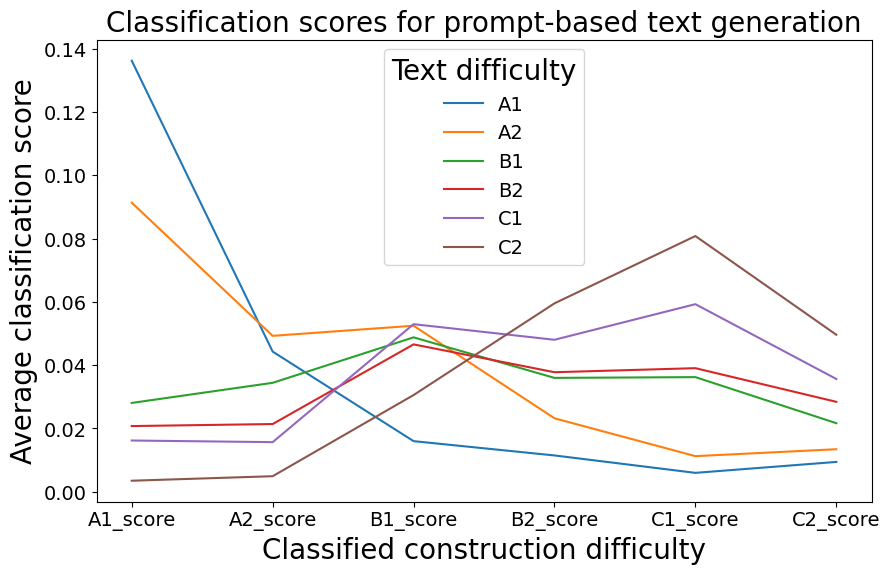

In [56]:
from matplotlib import rcParams

# Update default font sizes
rcParams.update({'font.size': 20, 'axes.labelsize': 20, 'axes.titlesize': 20, 'xtick.labelsize': 14,
                 'ytick.labelsize': 14, 'legend.fontsize': 14})

df_sorted = corr_df.sort_index(axis=1)

# Plotting
plt.figure(figsize=(10, 6))
for label in df_sorted.index:
    plt.plot(df_sorted.columns, df_sorted.loc[label, :], label=label)
plt.xlabel('Classified construction difficulty')
plt.ylabel('Average classification score')
plt.title('Classification scores for prompt-based text generation')
plt.legend(title="Text difficulty")
plt.savefig(f'../doc/generated_scores.pdf', transparent=True, bbox_inches='tight')